<a href="https://colab.research.google.com/github/ahsank/runml/blob/main/Fintest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a
* https://medium.com/auquan/cointegration-and-stationarity-f4d14e1b3aef
* https://github.com/Auquan/Tutorials/blob/master/Integration,%20Cointegration,%20and%20Stationarity.ipynb


In [16]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)


Stationary data A, Non sationary data B

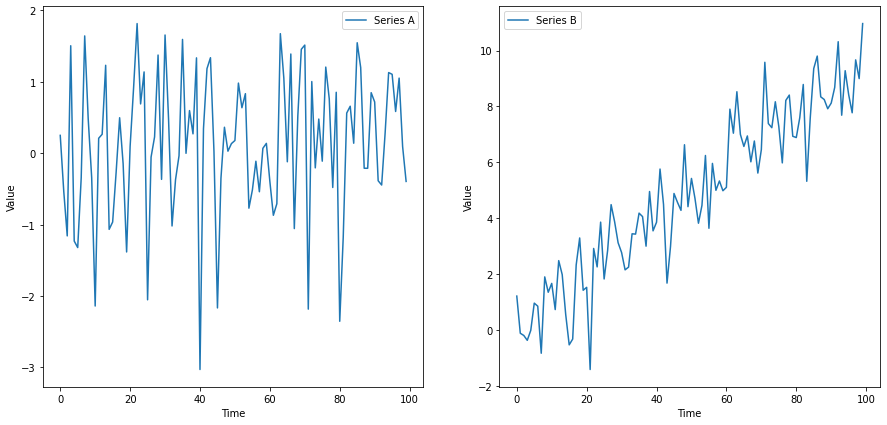

In [17]:

# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T), dtype=float)
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)
fig = plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])


# Set the number of datapoints
T = 100

B = pd.Series(index=range(T), dtype=float)
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.subplot(1,2,2)
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])
plt.show()

Checking for stationary

In [18]:
def check_for_stationarity(X, cutoff=0.01):
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

check_for_stationarity(A);
check_for_stationarity(B);

p-value = 7.196080449593451e-13 The series A is likely stationary.
p-value = 0.8904770846287285 The series B is likely non-stationary.


In [ ]:
!pip install  auquan_toolbox

In [ ]:
pip install -q yahoo_fin

In [ ]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

In [8]:
from yahoo_fin import stock_info as si
def get_data(ticker, start_date, end_date):
  df = si.get_data(ticker, start_date=start_date, end_date=end_date)
  # Remove duplicates
  df = df[~df.index.duplicated(keep='first')]
  return df

In [25]:
startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
ds = get_data('AAPL', startDateStr, endDateStr)
X = ds['adjclose']
X

2007-12-03     5.454156
2007-12-04     5.483126
2007-12-05     5.656636
2007-12-06     5.792334
2007-12-07     5.924984
                ...    
2017-11-24    41.663734
2017-11-27    41.454182
2017-11-28    41.211311
2017-11-29    40.356449
2017-11-30    40.920803
Name: adjclose, Length: 2518, dtype: float64

p-value = 0.9941055893965625 The series adjclose is likely non-stationary.
p-value = 0.0 The series adjclose Additive Returns is likely stationary.
p-value = 2.2663968095472915e-20 The series adjclose Multiplicative Returns is likely stationary.


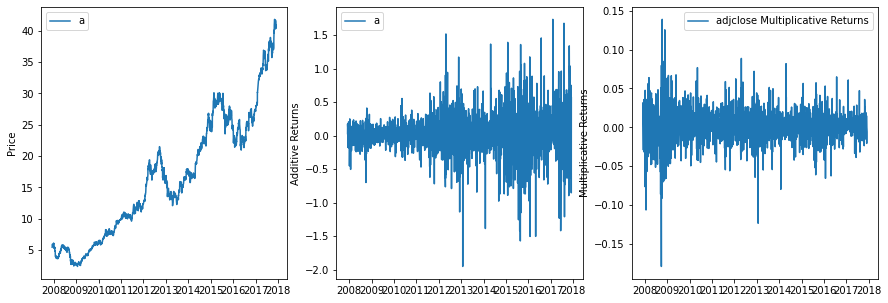

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend(X.name)
# plt.show()

check_for_stationarity(X)

X1 = X.diff()[1:]
X1.name = (str(X.name) + ' Additive Returns')
check_for_stationarity(X1)
plt.subplot(1, 3, 2)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend(X1.name)
# plt.show()

X2 = X.pct_change()[1:]
X2.name = str(X.name) + ' Multiplicative Returns'
check_for_stationarity(X2)
plt.subplot(1,3,3)
plt.plot(X2.index, X2.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X2.name])
plt.show()

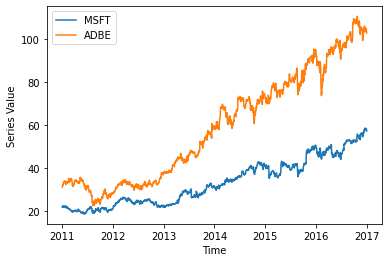

(-3.5589709806252032,
 0.027513677131827622,
 array([-3.90371244, -3.3401821 , -3.0472618 ]))

In [37]:
startDateStr = '2011/01/01'
endDateStr = '2017/01/01'
X1 = get_data('MSFT', startDateStr, endDateStr)['adjclose']
X2 = get_data('ADBE', startDateStr, endDateStr)['adjclose']
X1.name = 'MSFT'
X2.name = 'ADBE'
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()
from statsmodels.tsa.stattools import coint

coint(X1, X2)

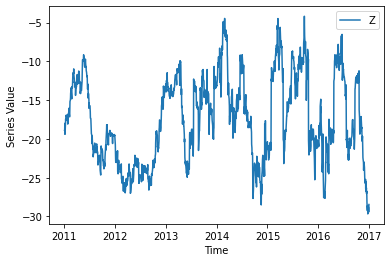

p-value = 0.004946122484862931 The series Z is likely stationary.


In [39]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1['MSFT']

results.params

b = results.params['MSFT']
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name])
plt.show()

check_for_stationarity(Z);
